## CAN Decoding Example
- Vehicle: 2019 Nissan Leaf
- Author: Will Martin
- Date: 08/03/2022

### Setup Library

In [1]:
# auto-reload library if developing library functionalities
%reload_ext autoreload
%autoreload 2

# import library
from PandaCANDecoder.decoder import Decoder
from PandaCANDecoder.dbc import dbc_str_to_signal

In [2]:
# other imports
import matplotlib.pyplot as plt

### Import Data

In [3]:
# Create decoder object with log file
can_decoder = Decoder('examples//can_data/example_can_data.csv')

In [4]:
# Generate message objects
can_decoder.generate_msgs()

Generating messages           : 100%|██████████| 99/99 [00:00<00:00, 6701.79it/s]


In [5]:
# Print messages
can_decoder.print_msgs()

-----------------------------------
Message ID: {Panda Number: [Buses]}
-----------------------------------
Message 0x760: {0: [0], 1: [0, 1, 2]}
Message 0x2f6: {1: [0]}
Message 0x3db: {1: [1, 2]}
Message 0x740: {1: [0, 1, 2]}
Message 0x551: {1: [0, 1, 2]}
Message 0x510: {1: [1, 2]}
Message 0x11a: {1: [2]}
Message 0x284: {1: [0, 2]}
Message 0x286: {1: [1]}
Message 0x580: {1: [1, 2]}
Message 0x285: {1: [0, 2]}
Message 0x5a9: {1: [1, 2]}
Message 0x292: {1: [0, 2]}
Message 0x1c3: {1: [2]}
Message 0x1cb: {1: [0, 2]}
Message 0x5b3: {1: [0, 1, 2]}
Message 0x185: {1: [0]}
Message 0x1cc: {1: [0, 2]}
Message 0x3f0: {1: [0]}
Message 0x209: {1: [2]}
Message 0x215: {1: [2]}
Message 0x2aa: {1: [0]}
Message 0x2b0: {1: [2]}
Message 0x216: {1: [2]}
Message 0x2ef: {1: [2]}
Message 0x193: {1: [0]}
Message 0x2: {1: [0, 1, 2]}
Message 0x280: {1: [0, 1, 2]}
Message 0x174: {1: [0, 2]}
Message 0x3a9: {1: [2]}
Message 0x176: {1: [2]}
Message 0x108: {1: [0, 2]}
Message 0x4f2: {1: [2]}
Message 0x3f3: {1: [0]}
M

In [6]:
# Generate time series message data. 
# Saved as numpy `uint64` array to `./time_series_msgs/{msg_id}.npy` for fast reading

# write .npy file only if it does not exist
# can_decoder.generate_msg_ts_data()

# force write all .npy files
can_decoder.generate_msg_ts_data(rewrite=True)

Generating message data       : 100%|██████████| 99/99 [00:02<00:00, 46.45it/s]


In [7]:
# Calculate predicted signals
can_decoder.calculate_signals(
        tokenization_method='conditional_bit_flip',
        signedness_method='msb_classifier',
        alpha1=0.01,
        alpha2=0.5,
        gamma1=0.2)

Generating signals            : 100%|██████████| 99/99 [00:00<00:00, 298.25it/s]


### Reference PID Signal: Accelerometer

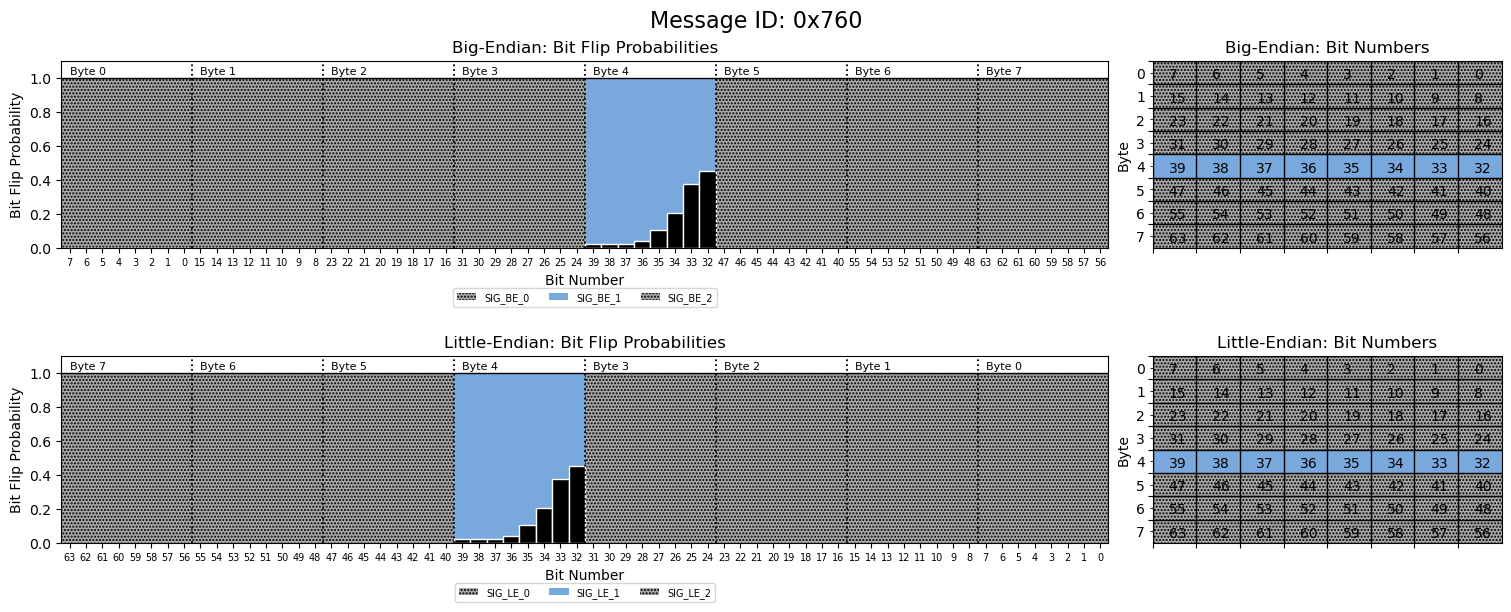

In [19]:
# Plot message decoding tool
can_decoder.plot_message_from_id('0x760')

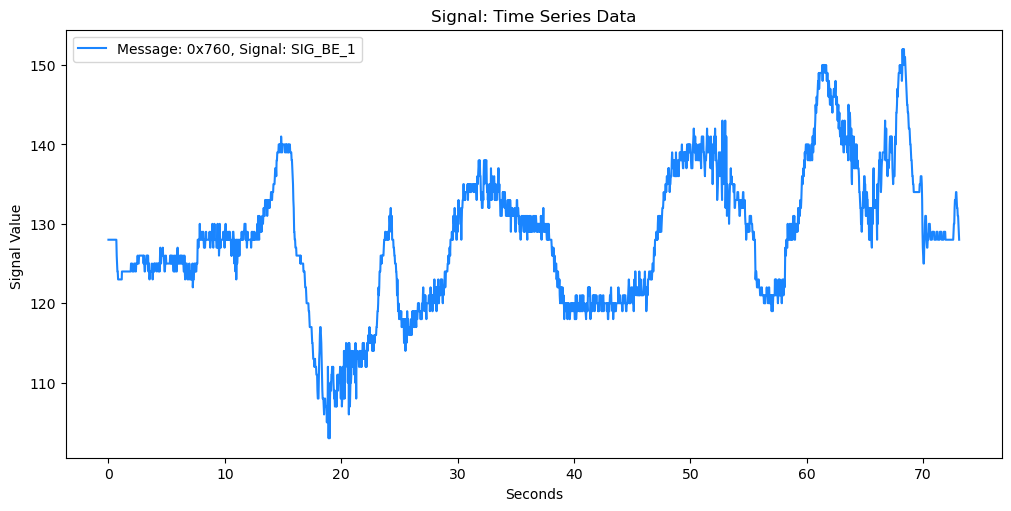

In [9]:
# Plot accelerometer signal data
ref_accel_signal = can_decoder.get_signal('0x760', 'SIG_BE_1')
can_decoder.plot_signal(ref_accel_signal)

### Signal Matching

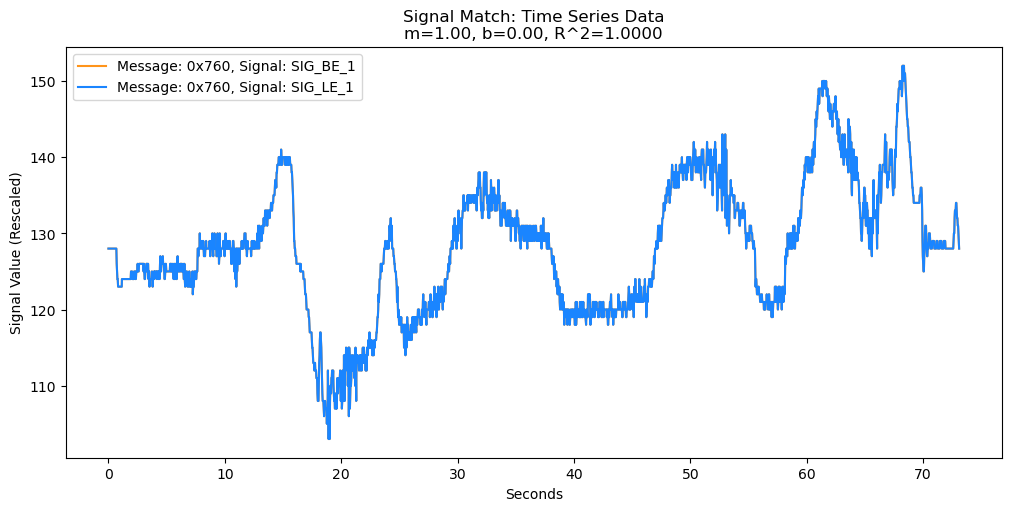

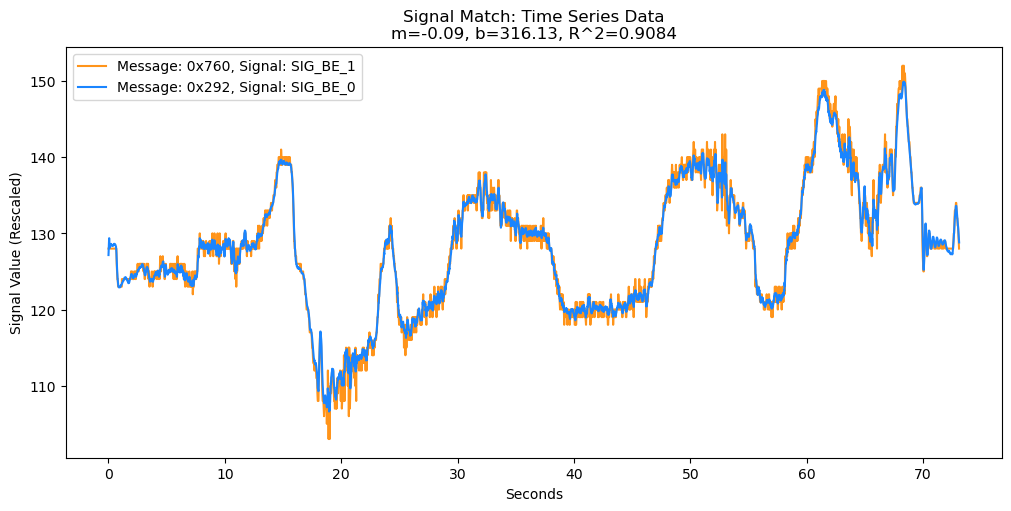

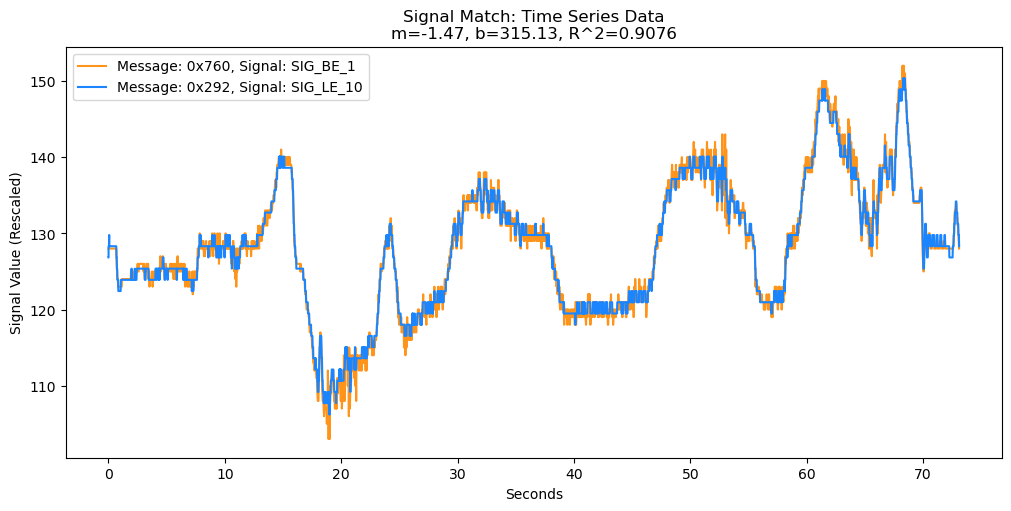

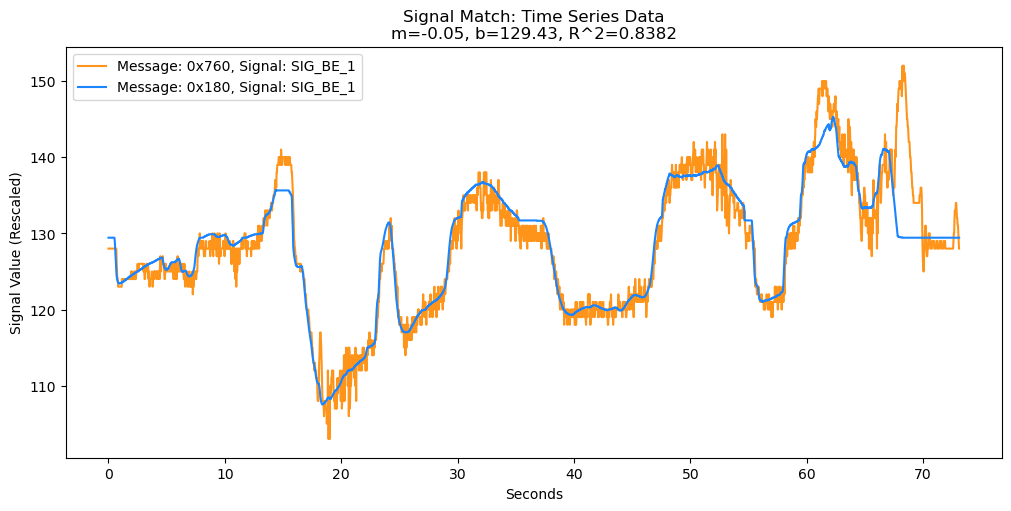

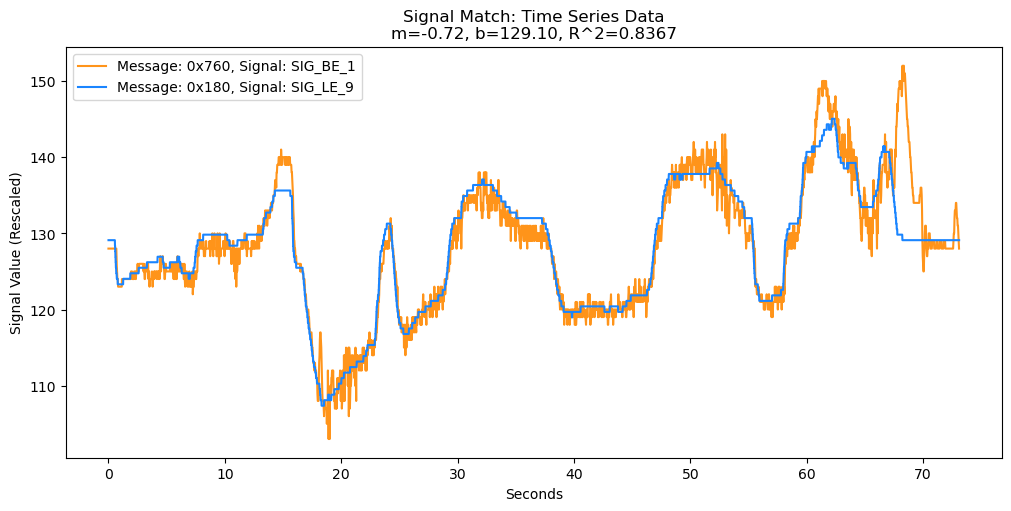

In [10]:
# Signal matching
can_decoder.find_signal_match(ref_accel_signal, thresh=0.8, plot=True)

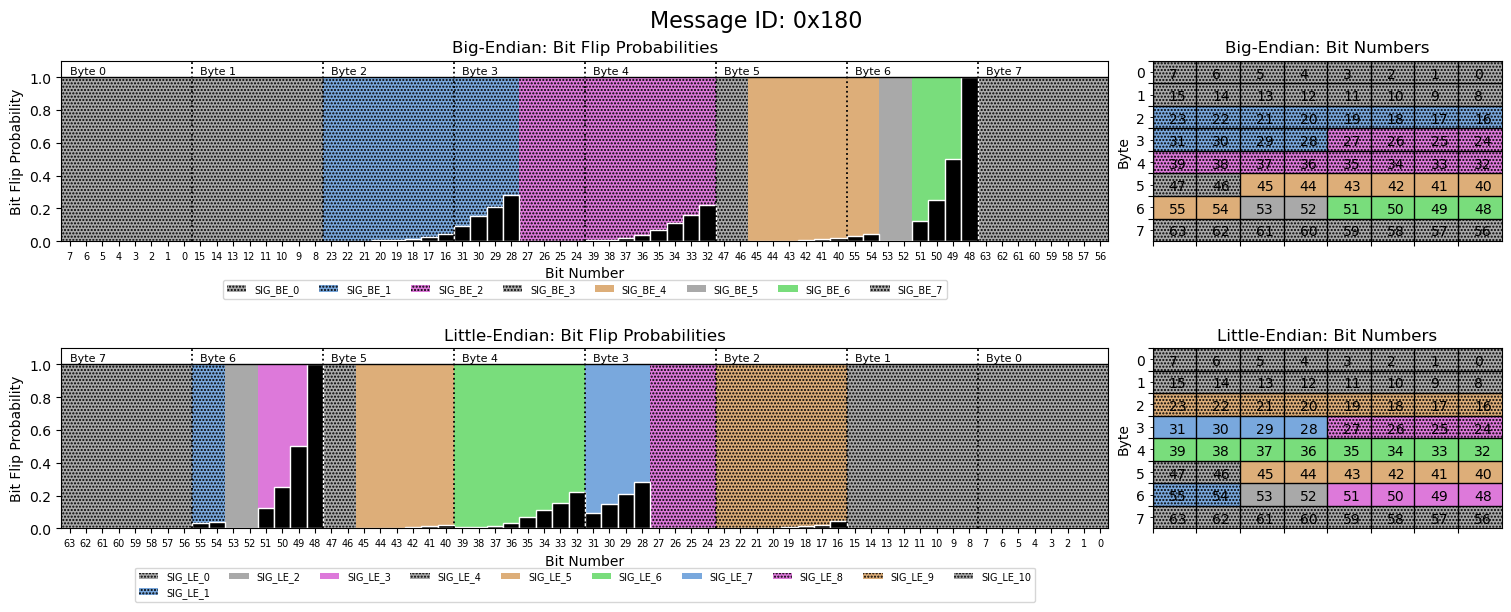

In [11]:
# Plot message decoding tool for canidate message
can_decoder.plot_message_from_id('0x180')

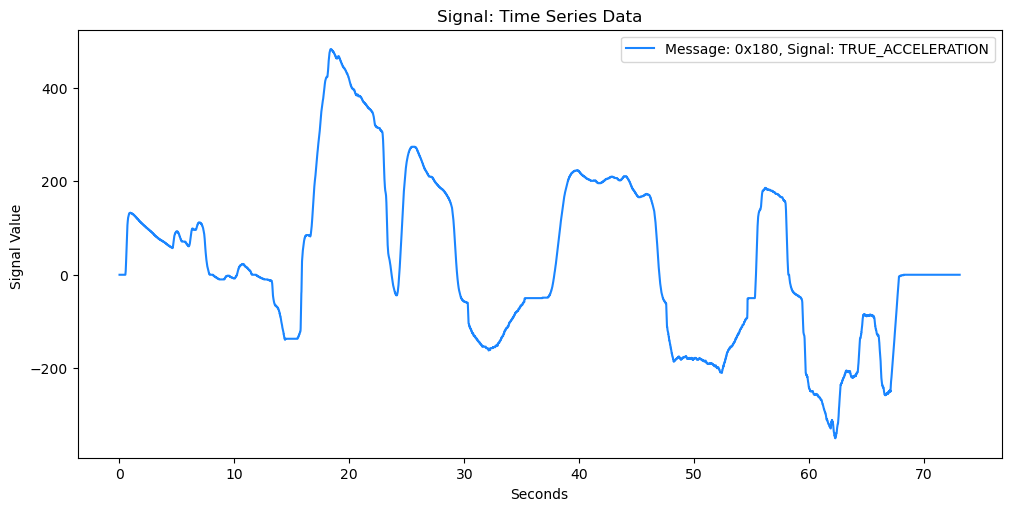

In [12]:
# Plot canidate true acceleration signal
true_accel_signal = can_decoder.get_signal('0x180', 'SIG_BE_1')
true_accel_signal.name = "TRUE_ACCELERATION"
can_decoder.plot_signal(true_accel_signal)

### Signal Scaling and DBC String Interaction

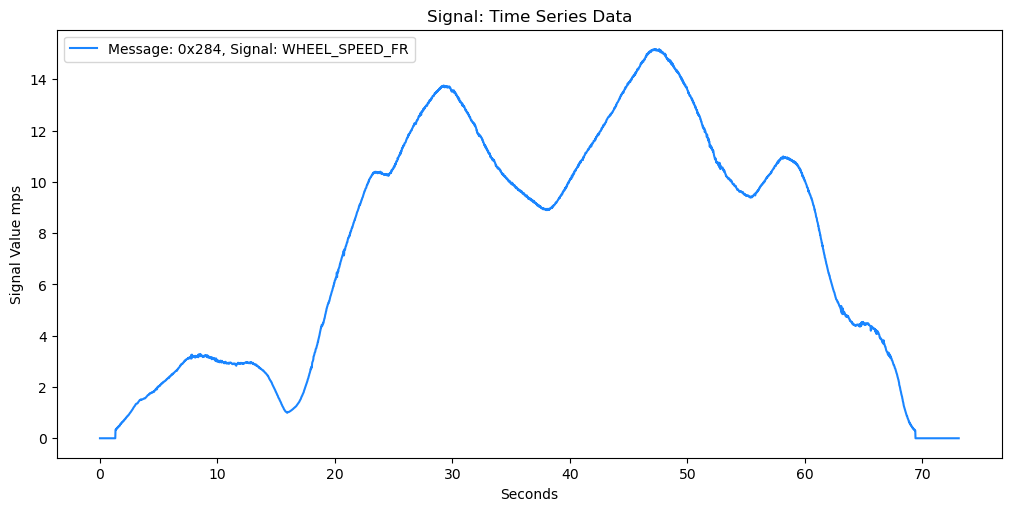

In [13]:
# Need correct scaling
# Differentiate known kph speed signal and match scaling

# Get wheel speed from dbc string defined here: 
#     https://github.com/commaai/opendbc/blob/master/nissan_leaf_2018.dbc#L99
wheel_speeds_front_msg = can_decoder.get_message('0x284')
dbc_str = 'SG_ WHEEL_SPEED_FR : 7|16@0+ (0.005,0) [0|65535] "KPH" XXX'
wheel_speed_fr_signal = dbc_str_to_signal(dbc_str, wheel_speeds_front_msg)

# Rescale to m/s
wheel_speed_fr_signal.factor = wheel_speed_fr_signal.factor * 1000 / (60*60)
wheel_speed_fr_signal.unit = "mps"

# Plot
can_decoder.plot_signal(wheel_speed_fr_signal)

In [14]:
# Numerically differentiate wheel speed
wheel_accel, wheel_accel_timestamps = wheel_speed_fr_signal.first_derivative_ts_data(sampling_rate=3)

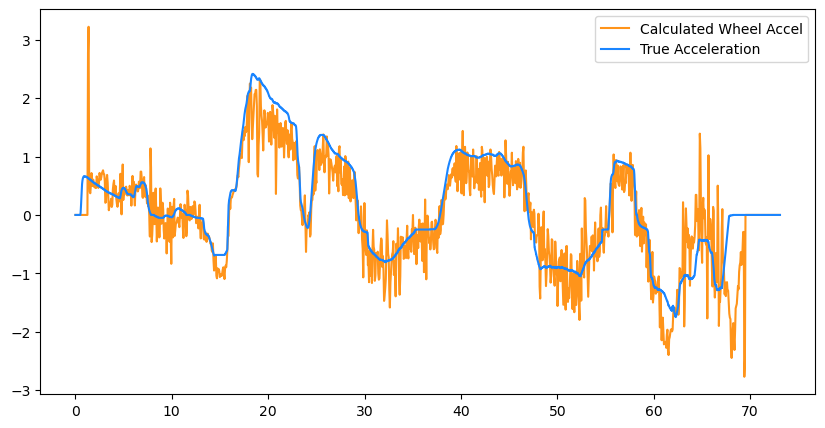

In [15]:
# Manually plot data and compare scalings
# TODO: add this functionality to PandaCANDecoder library

true_accel_signal.factor = 0.005

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(wheel_accel_timestamps, wheel_accel, label="Calculated Wheel Accel", color='#ff941a')
plt.plot(true_accel_signal.ts_data_timestamps, true_accel_signal.ts_data, label= "True Acceleration", color='#1a85ff')
plt.legend()
plt.show()

In [16]:
# Edit true acceleration attributes
true_accel_signal.unit = "m/s^2"
true_accel_signal.min = 0
true_accel_signal.max = 2**12-1

# Print DBC file string
print(true_accel_signal.dbc_str)

SG_ TRUE_ACCELERATION : 23|12@0- (0.005,0) [0|4095] "m/s^2" XXX


### Extra Plotting Tools

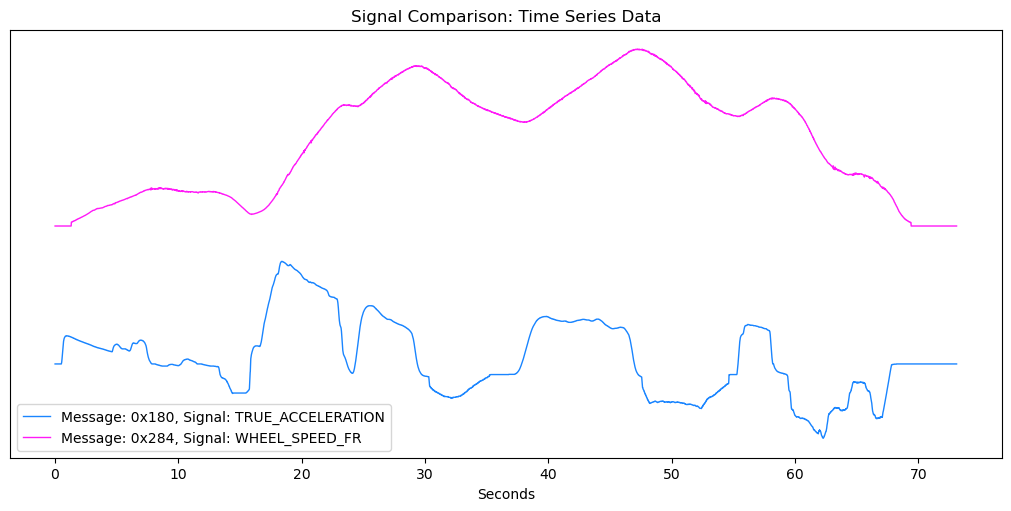

In [17]:
# Plot multiple signals together *with* autoscaling and stacking
can_decoder.plot_signal_multi([true_accel_signal, wheel_speed_fr_signal], autoscale=True)

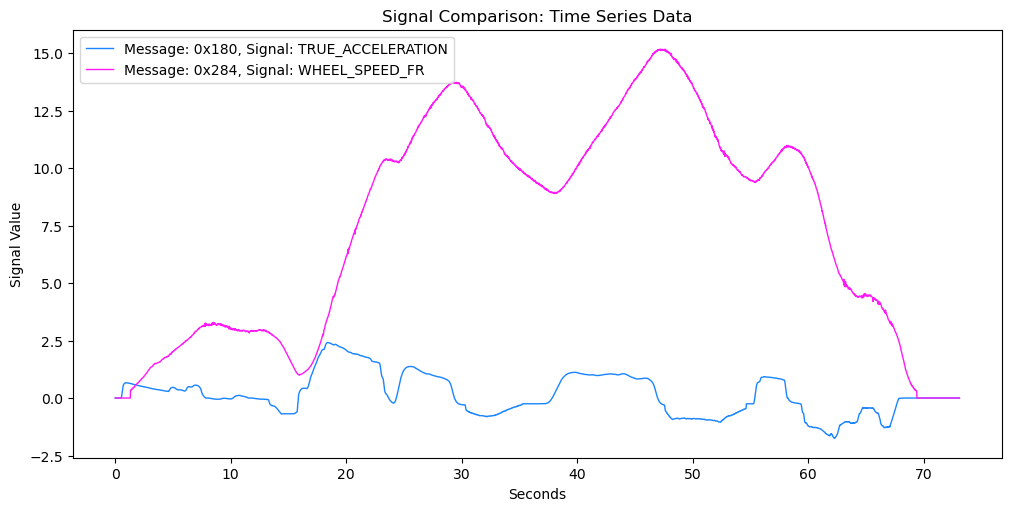

In [18]:
# Plot multiple signals together *without* autoscaling and stacking
can_decoder.plot_signal_multi([true_accel_signal, wheel_speed_fr_signal], autoscale=False)